# **Project 1**, MIE1626 Winter 2022
**Data Science Methods and Quantitative Analysis [90 Marks]**

**Deadline: October 14 at 21:00**

**Academic Integrity**

This project is individual: It is to be completed on your own. Do not share your code with others, or post any parts of your work online. You can only submit code that you have written yourself. If you use any online resource for developing parts of your code, acknowledge the source in a comment in your code. Students suspected of plagiarism on a project will be referred to the university for formal discipline according to the Code of Behaviour on Academic Matters.

Please fill out the following:


*   Name: Alvin Pane    
*   Student Number: 1004281118
*   UTorID: panealvi

**Submission:** Please submit both this notebook and a PDF version of it containing all the code and the outputs. 

## **Part 0: Loading needed libraries [0 Marks]**


In this project, we want to develop a statistical model for the mortality rate of lung cancer in the United States. 

One of the parts overlooked in a lot of data science courses is preprocessing. And a good way to learn about it is by solving a lot of examples and test cases. A big part of this project is walking you through preprocessing, making informed decisions using your observations, and exploratory data analysis. Then we use regression methods to construct models to predict the mortality rate of lung cancer using the features provided here.

In [1]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

## **Part 1: Getting started [40 Marks]**
## Loading data
Load the three csv files as pandas dataframes using a string 'path' for the location of files on your system (to be then updated by the marker for evaluation)

In [2]:
fulldf = pd.read_csv('https://saref.github.io/teaching/MIE1626/mydata.csv').drop(columns='Unnamed: 0')
data_dict = pd.read_csv('https://saref.github.io/teaching/MIE1626/descriptions.csv')
populationdf = pd.read_csv('https://saref.github.io/teaching/MIE1626/populations.csv')


Data set `mydata.csv` includes most of the data. Explantions on the meaning of each of the columns are included in `descriptions.csv`. Please take a couple of minutes understanding the structure of both files befor proceeding.

## Data cleaning
In this project, we try to go through the steps together. Please read through the instructions carefully. 


### 1.1 Convert `FIPS` column to correct format [5 Marks]
Federal Information Processing Standard or [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) are categorical variables. It is a five digit number with the first two digits showinh the state and the last three digits showing the county code. We recognize that while FPS is only numbers, is actually a categorical valriable.
First, check the format of the `FIPS` column and convert them to the five digit format with type `np.object_` as seen in the county level section, [here](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=county%2Dlevel%20%20%20%20%20%20place). 

*Hint*: You can use [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to first convert the type and then use [`str.pad`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.pad.html) to format the values as five digit numbers.

In [3]:
#Convert FIPS to standard 5 digit
FIPS = fulldf['FIPS']
FIPS=FIPS.astype(str)
FIPS=FIPS.str.pad(width=5,side ='left',fillchar='0')
fulldf['FIPS']=FIPS

fulldf['FIPS'].head()


0    02013
1    02016
2    02020
3    02050
4    02060
Name: FIPS, dtype: object

### 1.2 Check for null values [5 Marks]

Just check for null values and remove columns whenever the percentage of null values is greater than 20. Please provide a statement to support the columns you removed.

In [4]:
#Check for Null Values

#First in fulldf dataset
for column in fulldf:
    col = fulldf[column]
    length = len(col)
    null=pd.isnull(col).sum()
    percent_null = null/length * 100 
    if percent_null > 20:
        print("column removed: ")
        print(column)
        fulldf=fulldf.drop(column,axis=1)
    
#Then in populationdf dataset
for column in populationdf:
    col = populationdf[column]
    length = len(col)
    null=pd.isnull(col).sum()
    percent_null = null/length * 100 
    if percent_null > 20:
        print("column removed: ")
        print(column)
        populationdf=populationdf.drop(column,axis=1)

print(" ")
print("We are removing all columns which have 20% or more of their values missing. This is because we are simply missing too much of the information for this variable to effectively be considered in our regression, which may worsen our predictions. ")

column removed: 
Med_Income_Black
column removed: 
Med_Income_Nat_Am
column removed: 
Med_Income_Asian
column removed: 
Med_Income_Hispanic
 
We are removing all columns which have 20% or more of their values missing. This is because we are simply missing too much of the information for this variable to effectively be considered in our regression, which may worsen our predictions. 


### 1.3 Check the format of columns [5 Marks]
Report the format of each column. List the columns that are in a wrong format and state why you think that is the case.

*Hint*: You can do this by either inspecting the dataframe or by writing a code snippet that tells you what cells cannot be reformatted to the correct format.

In [5]:
print("The columns that are in the wrong format are:")
for column in fulldf:
    #print(column)
    col = fulldf[column]
    if col.dtypes == 'object':
        print(column)
    #print(col.dtypes)


The columns that are in the wrong format are:
State
AreaName
FIPS
Incidence_Rate
Avg_Ann_Incidence
Recent_Trend
Mortality_Rate
Avg_Ann_Deaths


In [6]:
print("These columns are in the wrong format as they are of type 'object', which means that they contain strings and potentially a mix of strings and numbers. State, AreaName, FIPS, and Recent_Trend are all categorical variables and have strings, these will either need to be dropped or replaced with dummy variables for use in regression. Incidence_Rate, Avg_Ann_Incidence, Recent_Trend, Mortality_Rate, Avg_Ann_Deaths have their values polluted with random entries such as '*', '_' and '__', as well as random commas in some numerical entries. These columns will need to be cleaned up and put into the correct format in subsequent sections.")

These columns are in the wrong format as they are of type 'object', which means that they contain strings and potentially a mix of strings and numbers. State, AreaName, FIPS, and Recent_Trend are all categorical variables and have strings, these will either need to be dropped or replaced with dummy variables for use in regression. Incidence_Rate, Avg_Ann_Incidence, Recent_Trend, Mortality_Rate, Avg_Ann_Deaths have their values polluted with random entries such as '*', '_' and '__', as well as random commas in some numerical entries. These columns will need to be cleaned up and put into the correct format in subsequent sections.


### 1.4 Add the population data to the main data frame [5 Marks]
You already know about FIPS. You can use the state and county columns in this dataset to construct a FIPS column in the same format as the main data frame. Then add the population data to the main data frame.

In [7]:
#Merge State and County into a Single FIPS column encoding the same information
state=populationdf['STATE']
county=populationdf['COUNTY']
state=state.astype(str)
county=county.astype(str)
state=state.str.pad(width=2,side ='left',fillchar='0')
county=county.str.pad(width=3,side ='left',fillchar='0')
FIPS = state+county
populationdf=populationdf.drop('STATE',axis=1)
populationdf=populationdf.drop('COUNTY',axis=1)
populationdf=populationdf.drop('Unnamed: 0',axis=1)
populationdf['FIPS']=FIPS

#Merge fulldf and population df on the FIPS data column
fulldf = pd.merge(fulldf, populationdf, on="FIPS", how="left")


### 1.5 Cleaning the output column `Mortality_Rate` [10 Marks]
Using the file `descriptions.csv`, explain what the non-numerical values of `Mortality_Rate` mean. 

Then, it is decision making time, we have to decide whether to remove the non-numerical values from `Mortality_Rate` or to assign a specific numerical value to them. This decision is based on you inferring if the non-numerical values were caused by noise and faults in data gathering or not. 

Note that if the observations are valid and are deleted, we are adding a bias to the model.

*Hint*: To get the full mark for this part, do two different analyses. Then use them to support your decision on removing or modifying the non-numerical values. Either choice can result in the full mark if the supporting arguments are adequate.

In [8]:
print("The non-numerical values, or '*' entries in Mortality Rate mean that there are fewer than 16 reported cases, meaning there is not enough data to report an accurate entry here. We will investigate 2 cases of handling this, removing the values or replacing them with 0.")

#Why is this? Look at populations of places with "*" entries, low population numbers suggest valid data, 
#if the population is high then something might be wrong with data collection. Lets Investigate:

mort_rate = fulldf['Mortality_Rate']

#get avg of populations with * and avg of all populations
populations = []
for i in range(len(mort_rate)):
    if mort_rate[i] == '*':
        populations.append(fulldf['POPESTIMATE2015'][i])
        #print(fulldf['POPESTIMATE2015'][i])

print(" ")
print("Z-Score Analysis")
print(" ")

print("%% Case 1, Removing Values %%")
mort_rate1 = mort_rate[mort_rate != '*'].astype(np.float64)
zscore = (mort_rate1 - mort_rate1.mean())/mort_rate1.std(ddof=0)
num_outliers = len(zscore[zscore > 3]) + len(zscore[zscore < -3])
#print(mort_rate2.mean())
#print(mort_rate2.std())
print("The number of outliers based on z-score for Case 1 is:")
print(num_outliers)
print(" ")

print("%% Case 2, Assigning Values %%")
mort_rate2 = mort_rate.replace('*', 0).astype(np.float64)
zscore = (mort_rate2 - mort_rate2.mean())/mort_rate2.std(ddof=0)
num_outliers = len(zscore[zscore > 3]) + len(zscore[zscore < -3])
#print(mort_rate2.mean())
#print(mort_rate2.std())
print("The number of outliers based on z-score for Case 2 is:")
print(num_outliers)
print(" ")

print(" ")
print("Population Size Analysis")
print(" ")

mean_pop = sum(populations)/len(populations)
print("Average population estimate of areas with '*' entries")
print(mean_pop)

total_mean_pop = sum(fulldf['POPESTIMATE2015'])/len(fulldf['POPESTIMATE2015'])
print("Average population estimate of all areas")
print(total_mean_pop)

fulldf['Mortality_Rate']=mort_rate2
print(" ")
print("Conclusion: Removing values results in a higher number of data entries for which the zscore is greater than abs(3). This means there are more outliers in the data, as a zscore with greater than abs(3) corresponds to an entry that lies farther than 3 standard deviations from the mean. Looking at the population data, we can also see that areas with '*' entries have a significantly lower average population than the overall average. It would be reasonable to expect regions with significantly lower populations to have significantly lower case counts. Deleting the data would also be introducing a bias, which from the analysis just conducted, we have no basis for introducing as we have no reason to believe that the data is faulty. The data for Mortality Rate is valid, the only issue is that there are few cases to base it on, thus we will replace it with an assigned value of 0. ")
#print(populations)
#print()

The non-numerical values, or '*' entries in Mortality Rate mean that there are fewer than 16 reported cases, meaning there is not enough data to report an accurate entry here. We will investigate 2 cases of handling this, removing the values or replacing them with 0.
 
Z-Score Analysis
 
%% Case 1, Removing Values %%
The number of outliers based on z-score for Case 1 is:
21
 
%% Case 2, Assigning Values %%
The number of outliers based on z-score for Case 2 is:
6
 
 
Population Size Analysis
 
Average population estimate of areas with '*' entries
3917.7784615384617
Average population estimate of all areas
102521.86151882578
 
Conclusion: Removing values results in a higher number of data entries for which the zscore is greater than abs(3). This means there are more outliers in the data, as a zscore with greater than abs(3) corresponds to an entry that lies farther than 3 standard deviations from the mean. Looking at the population data, we can also see that areas with '*' entries have a

### 1.6 Reformat the rest of the columns specified in 1.3 to numerical [5 Marks]
In each column reformat all the cells that you can. 

*Hint*: The cells that you cannot reformat, you can keep until you decide if you want to use the specific column in the model. Because you want to lose as least data as possible. So you can drop the associated rows if you want to use the column and keep them if the specific column is not used.

In [9]:
#To start, let's replace all the * with 0, as warranted by the 2 analyses in section 1.5
fulldf = fulldf.replace('*',0)

In [10]:
#Fix Avg Ann Deaths

#Some numerical values here contain commas (ex 1,463), to convert these numbers to a version python can understand, we remove the comma and cast
#the number as a float
fulldf['Avg_Ann_Deaths'] = fulldf['Avg_Ann_Deaths'].str.replace(',','')
fulldf['Avg_Ann_Deaths'] = fulldf['Avg_Ann_Deaths'].astype(np.float64)



In [11]:
#Fix Incidence Rate, remove "_"

#Missing data, we cannot infer anything about it, we must remove the rows
fulldf = fulldf[fulldf.Incidence_Rate != '_']
fulldf = fulldf[fulldf.Incidence_Rate != '__']
#Fix the Corrupted Entries
fulldf['Incidence_Rate']=fulldf['Incidence_Rate'].str.replace(' #','')
#Convert to Numerical Form
fulldf["Incidence_Rate"] =fulldf["Incidence_Rate"].astype(np.float64)


In [12]:
#Look to remove some useless columns once we convert things to numerical

fulldf=fulldf.drop('State',axis=1) #redundant, FIPS
fulldf=fulldf.drop('AreaName',axis=1) #redundant, FIPS
fulldf=fulldf.drop('Avg_Ann_Incidence',axis=1) #too much garbage data, redundant given incidence rate which gives us this data per 100k pop
#fulldf=fulldf.drop('Recent_Trend',axis=1)

In [13]:
print(fulldf['Recent_Trend'].value_counts())


# Test experiment to see whether to keep or drop Recent_Trend
fulldf2 = fulldf[fulldf.Recent_Trend != 0]
fulldf2 = fulldf[fulldf.Recent_Trend != '_']
fulldf2 = fulldf[fulldf.Recent_Trend != '__']
#Dummy Variables
fulldf2['Recent_Trend'] = fulldf2['Recent_Trend'].map({'stable':0, 'falling':1, 'rising':2})

stable_mean = fulldf2.Mortality_Rate[fulldf2.Recent_Trend == 0].mean()
print("stable mean mort rate")
print(stable_mean)
rising_mean = fulldf2.Mortality_Rate[fulldf2.Recent_Trend == 1].mean()
print("rising mean mort rate")
print(rising_mean)
falling_mean = fulldf2.Mortality_Rate[fulldf2.Recent_Trend == 2].mean()
print("falling mean mort rate")
print(falling_mean)

print("Looking at this column 83% of the entries are stable, 9% are null, 6.7% are falling, 1.4% are rising. The second most prevalent entry is one that has missing or corrupted data. Since over 90% of the data is either the same value or corrupted entries, this column may not be very useful in predicting the output variable, thus we will drop it. Similar values will not do anything to help the model differentiate between different responses.")
print("Further warranting dropping the column, we see that the mean mortality rates are very similar between 'stable', 'rising', and 'falling'. So this column indeed may not help us predict the output response")

fulldf= fulldf.drop('Recent_Trend',axis=1)

stable     2426
0           258
falling     198
rising       43
Name: Recent_Trend, dtype: int64
stable mean mort rate
53.01834295136026
rising mean mort rate
49.41414141414141
falling mean mort rate
46.58837209302325
Looking at this column 83% of the entries are stable, 9% are null, 6.7% are falling, 1.4% are rising. The second most prevalent entry is one that has missing or corrupted data. Since over 90% of the data is either the same value or corrupted entries, this column may not be very useful in predicting the output variable, thus we will drop it. Similar values will not do anything to help the model differentiate between different responses.
Further warranting dropping the column, we see that the mean mortality rates are very similar between 'stable', 'rising', and 'falling'. So this column indeed may not help us predict the output response


In [14]:
fulldf = fulldf.drop('FIPS',axis=1)

print('FIPS is a categorical variable, in this dataset the categories do not appear multiple times, thus we cannot use it to evaluate the model on both test and validation sets. We will drop it here.')

FIPS is a categorical variable, in this dataset the categories do not appear multiple times, thus we cannot use it to evaluate the model on both test and validation sets. We will drop it here.


In [15]:
#Ensure there are no NaNs before proceeding
fulldf=fulldf.fillna(0)

### 1.7 Make the numerical data useful [5 Marks]
We know we have a lot of columns of data, some of them are dependent on the populations. As a *Hint*, convert all the raw data to per 100,000 persons data (divide by population and multiply by 100,000).

In [16]:
#Loop over the columns that are in Raw data form, and convert them to per 100k pop data, divide by pop and multiply by 100k
print("Columns Converted:")
for column in fulldf:
    if column != 'Incidence_Rate' and column != 'Recent_Trend' and column != 'Mortality_Rate' and column != 'FIPS' and column != 'POPESTIMATE2015' and column != 'Med_Income' and column != 'Med_Income_White':
        fulldf[column] = (fulldf[column].astype(np.float64)/fulldf['POPESTIMATE2015'])*100000
        print(column)
             

Columns Converted:
All_Poverty
M_Poverty
F_Poverty
M_With
M_Without
F_With
F_Without
All_With
All_Without
Avg_Ann_Deaths


## **Part 2: Exploratory analysis [15 Marks]**

### 2.1 Visualizing different inputs [5 Marks]
Here show different inputs and how they change with respect to each other.
*Hint*: A good function to use here is `sns.pairplot`. Remember to have the plots well labeled and self explanatory.


In [17]:
#Breaking all the remaining columns into 3 groups to analyze them in 3 smaller pairplots
sub1 = fulldf[["All_Poverty","M_Poverty","F_Poverty","Med_Income","Med_Income_White","Mortality_Rate"]]
sub2 = fulldf[["M_With","M_Without", "F_With", "F_Without","All_With","Mortality_Rate"]]
sub3 = fulldf[["All_Without", "Incidence_Rate", "POPESTIMATE2015", "Avg_Ann_Deaths","Mortality_Rate"]]

The follow plot displays various features plotted against each other. We are interested in noticing which features have correlations with each other and with the response Mortality_Rate.


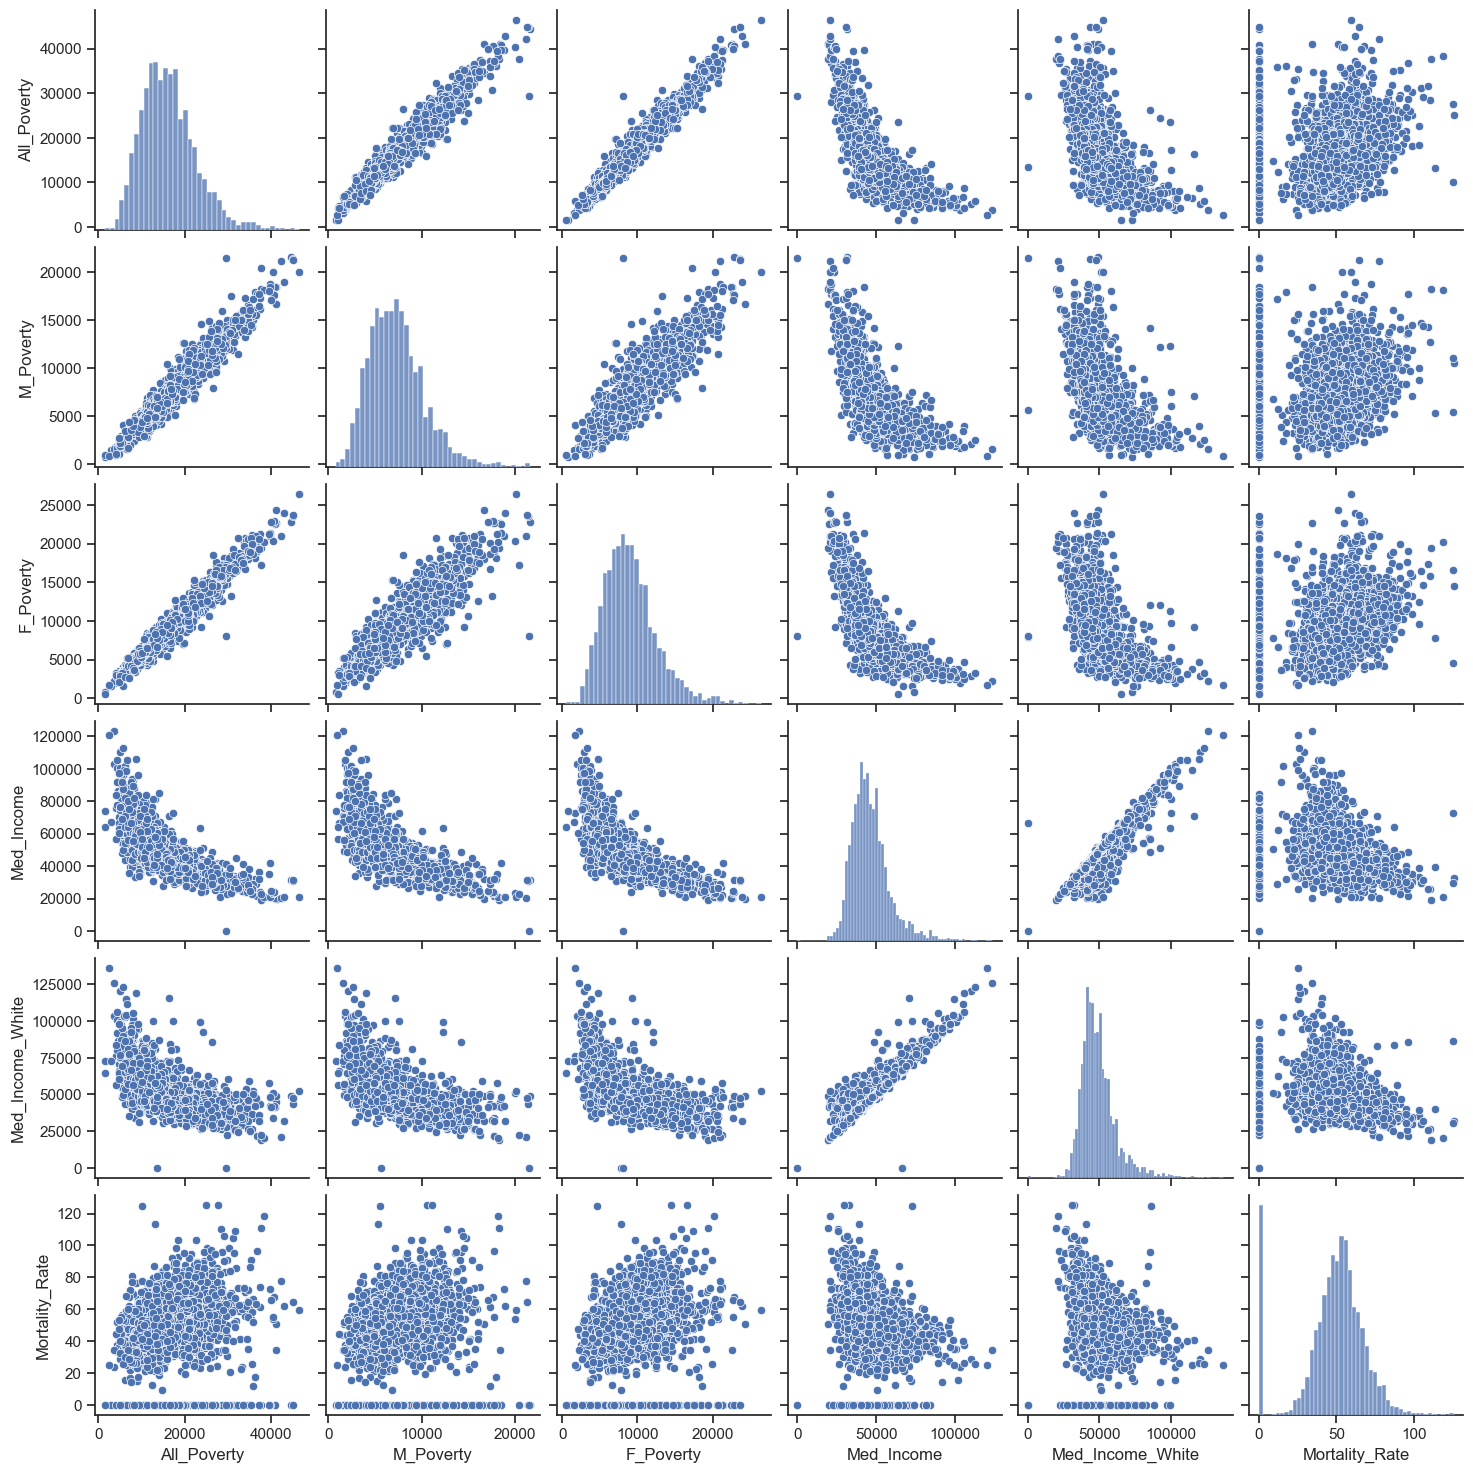

In [18]:
#Try subsets of features for pairplot

print("The follow plot displays various features plotted against each other. We are interested in noticing which features have correlations with each other and with the response Mortality_Rate.")
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(sub1)

plt.show()

The follow plot displays various features plotted against each other. We are interested in noticing which features have correlations with each other and with the response Mortality_Rate.


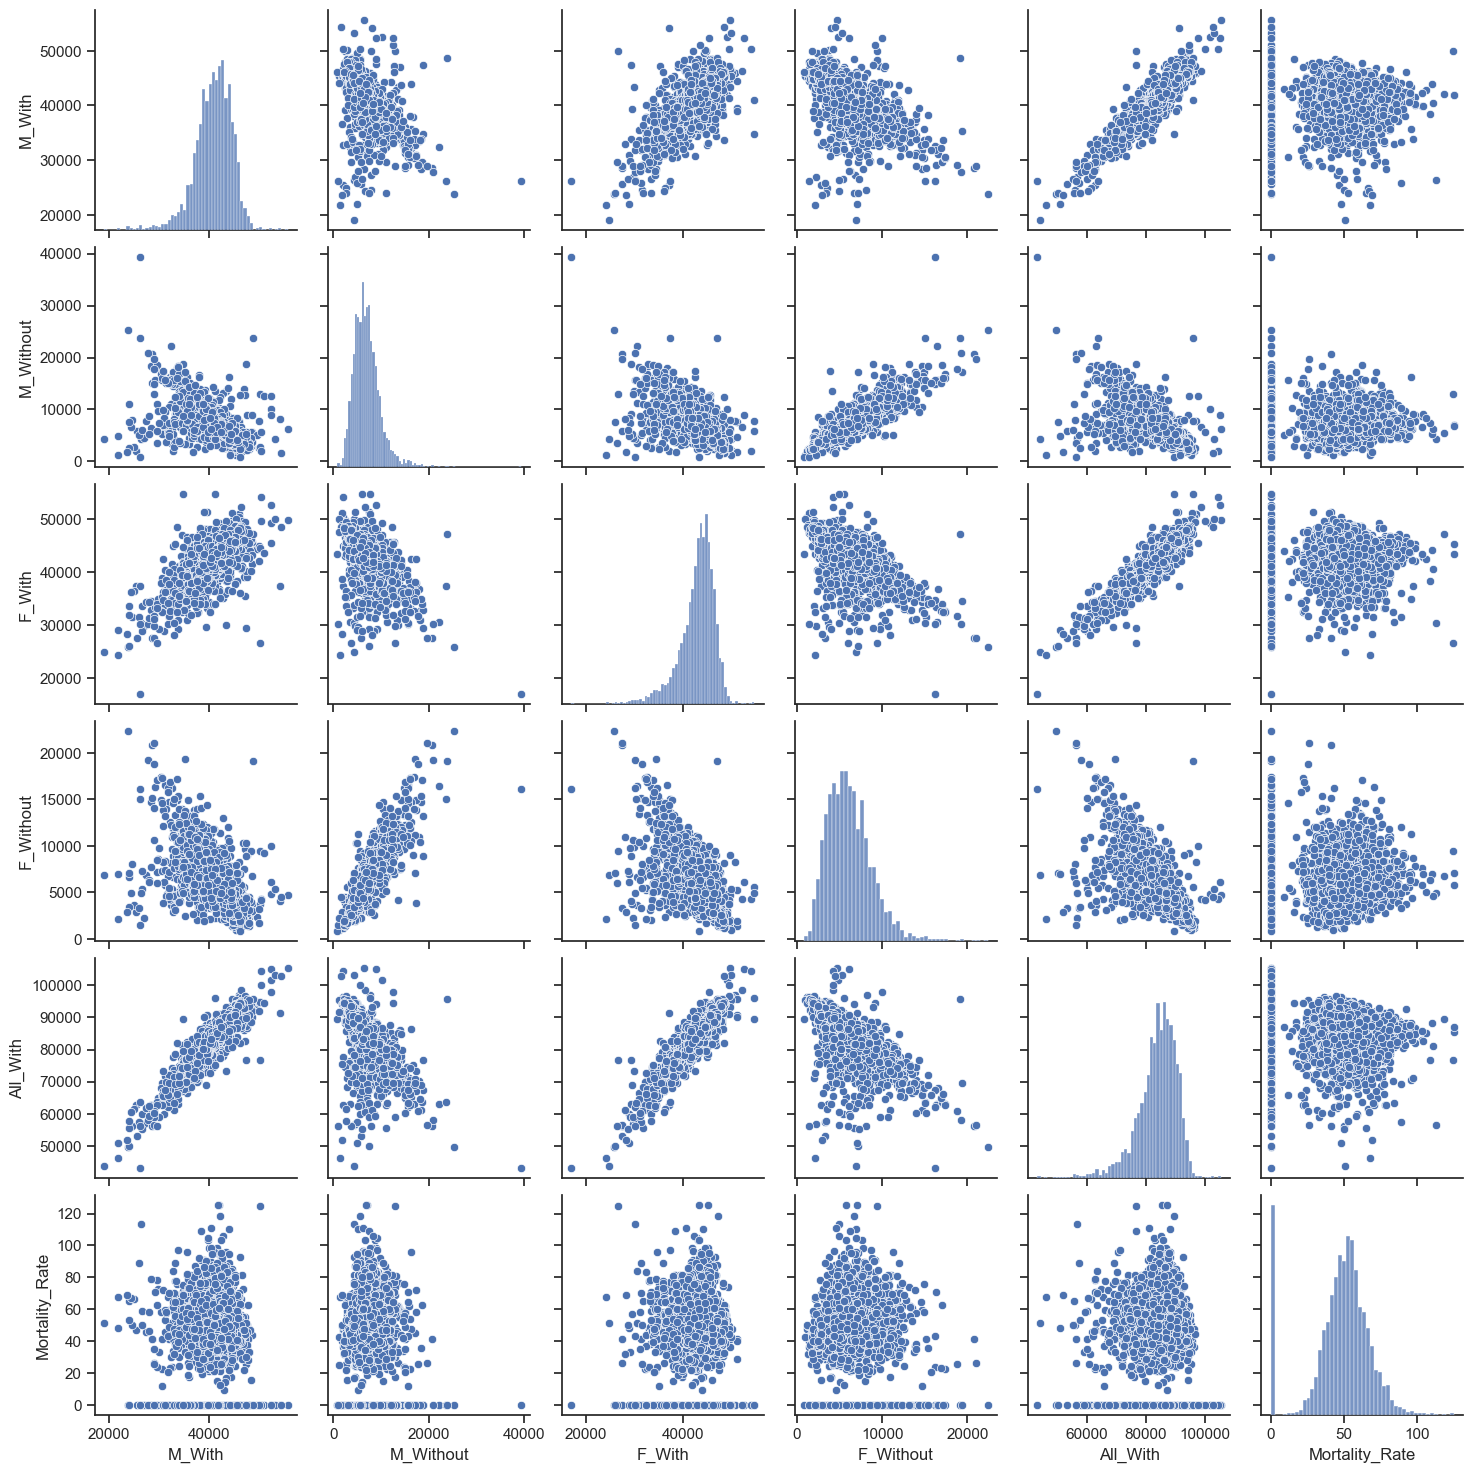

In [19]:
#Try subsets of features for pairplot

print("The follow plot displays various features plotted against each other. We are interested in noticing which features have correlations with each other and with the response Mortality_Rate.")
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(sub2)

plt.show()

The follow plot displays various features plotted against each other. We are interested in noticing which features have correlations with each other and with the response Mortality_Rate.


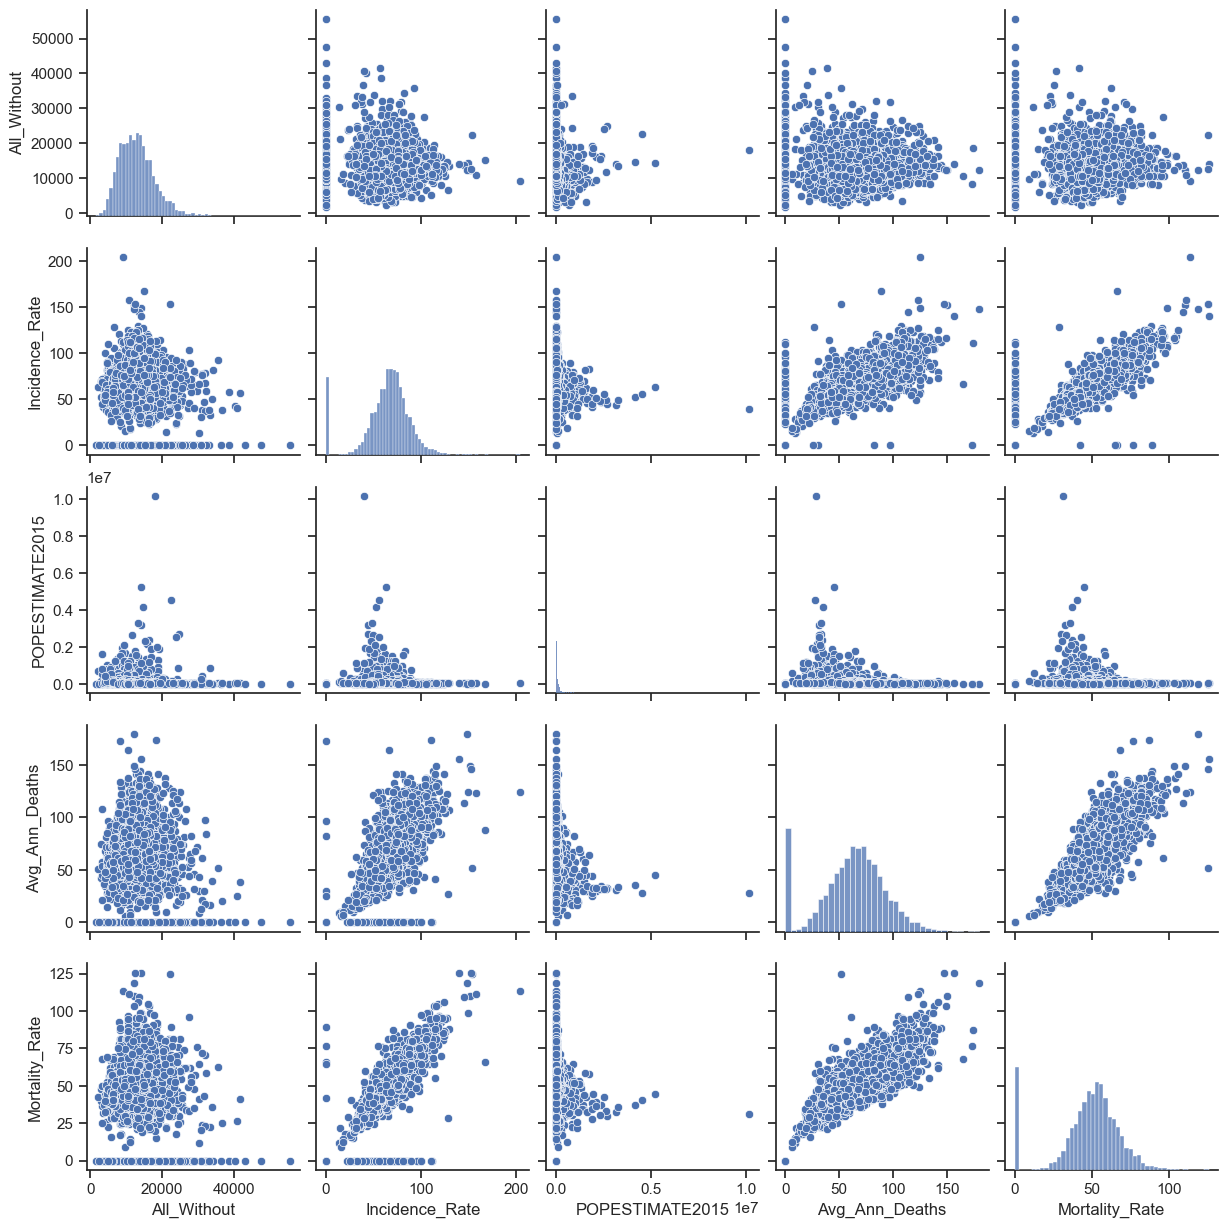

In [20]:
#Try subsets of features for pairplot

print("The follow plot displays various features plotted against each other. We are interested in noticing which features have correlations with each other and with the response Mortality_Rate.")
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(sub3)

plt.show()

### 2.2 Selecting the most important features [10 Marks]
In this step, we want to remove the redundant features. 

*Hint*: This can be done by analyzing the correlation between the features and removing the highly correlated one. Remember, throughout the project, write down specific reasons for any desicion you make.

In [21]:
correlated_features = set()
correlation_matrix = fulldf.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90: 
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

#We're going to remove columns that have correlation greater than 90%. This is because they have an extremely high correlation,
# telling basically the same data and will not be interesting predictors. 

In [22]:
print("The set of features with correlation greater than 90% are:")
print(correlated_features)


The set of features with correlation greater than 90% are:
{'Med_Income_White', 'F_Poverty', 'M_Poverty', 'All_With', 'All_Without'}


In [23]:
#Remove the correlated columns from fulldf
print("Let's remove these heavily correlated features:")
for column in correlated_features:
    if column != 'Mortality_Rate':
        print(column)
        fulldf=fulldf.drop(column,axis=1)

Let's remove these heavily correlated features:
Med_Income_White
F_Poverty
M_Poverty
All_With
All_Without


In [24]:
fulldf.head()

,All_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,Incidence_Rate,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
0,16551.930560,61518.0,26219.694702,39419.335528,16941.035618,16162.825501,0.0,0.0,0.000000,3341
1,8751.315328,84306.0,43318.133988,13486.495966,29936.864258,9891.266222,0.0,0.0,0.000000,5702
2,8006.160130,78326.0,40424.848089,7782.185842,40986.959942,7162.155376,61.5,47.3,32.139808,298695
3,24317.396634,51012.0,35640.254096,15089.713585,36927.449014,9885.211189,62.7,58.3,27.861362,17946
4,7735.426009,79750.0,46973.094170,13901.345291,39125.560538,7511.210762,0.0,0.0,0.000000,892


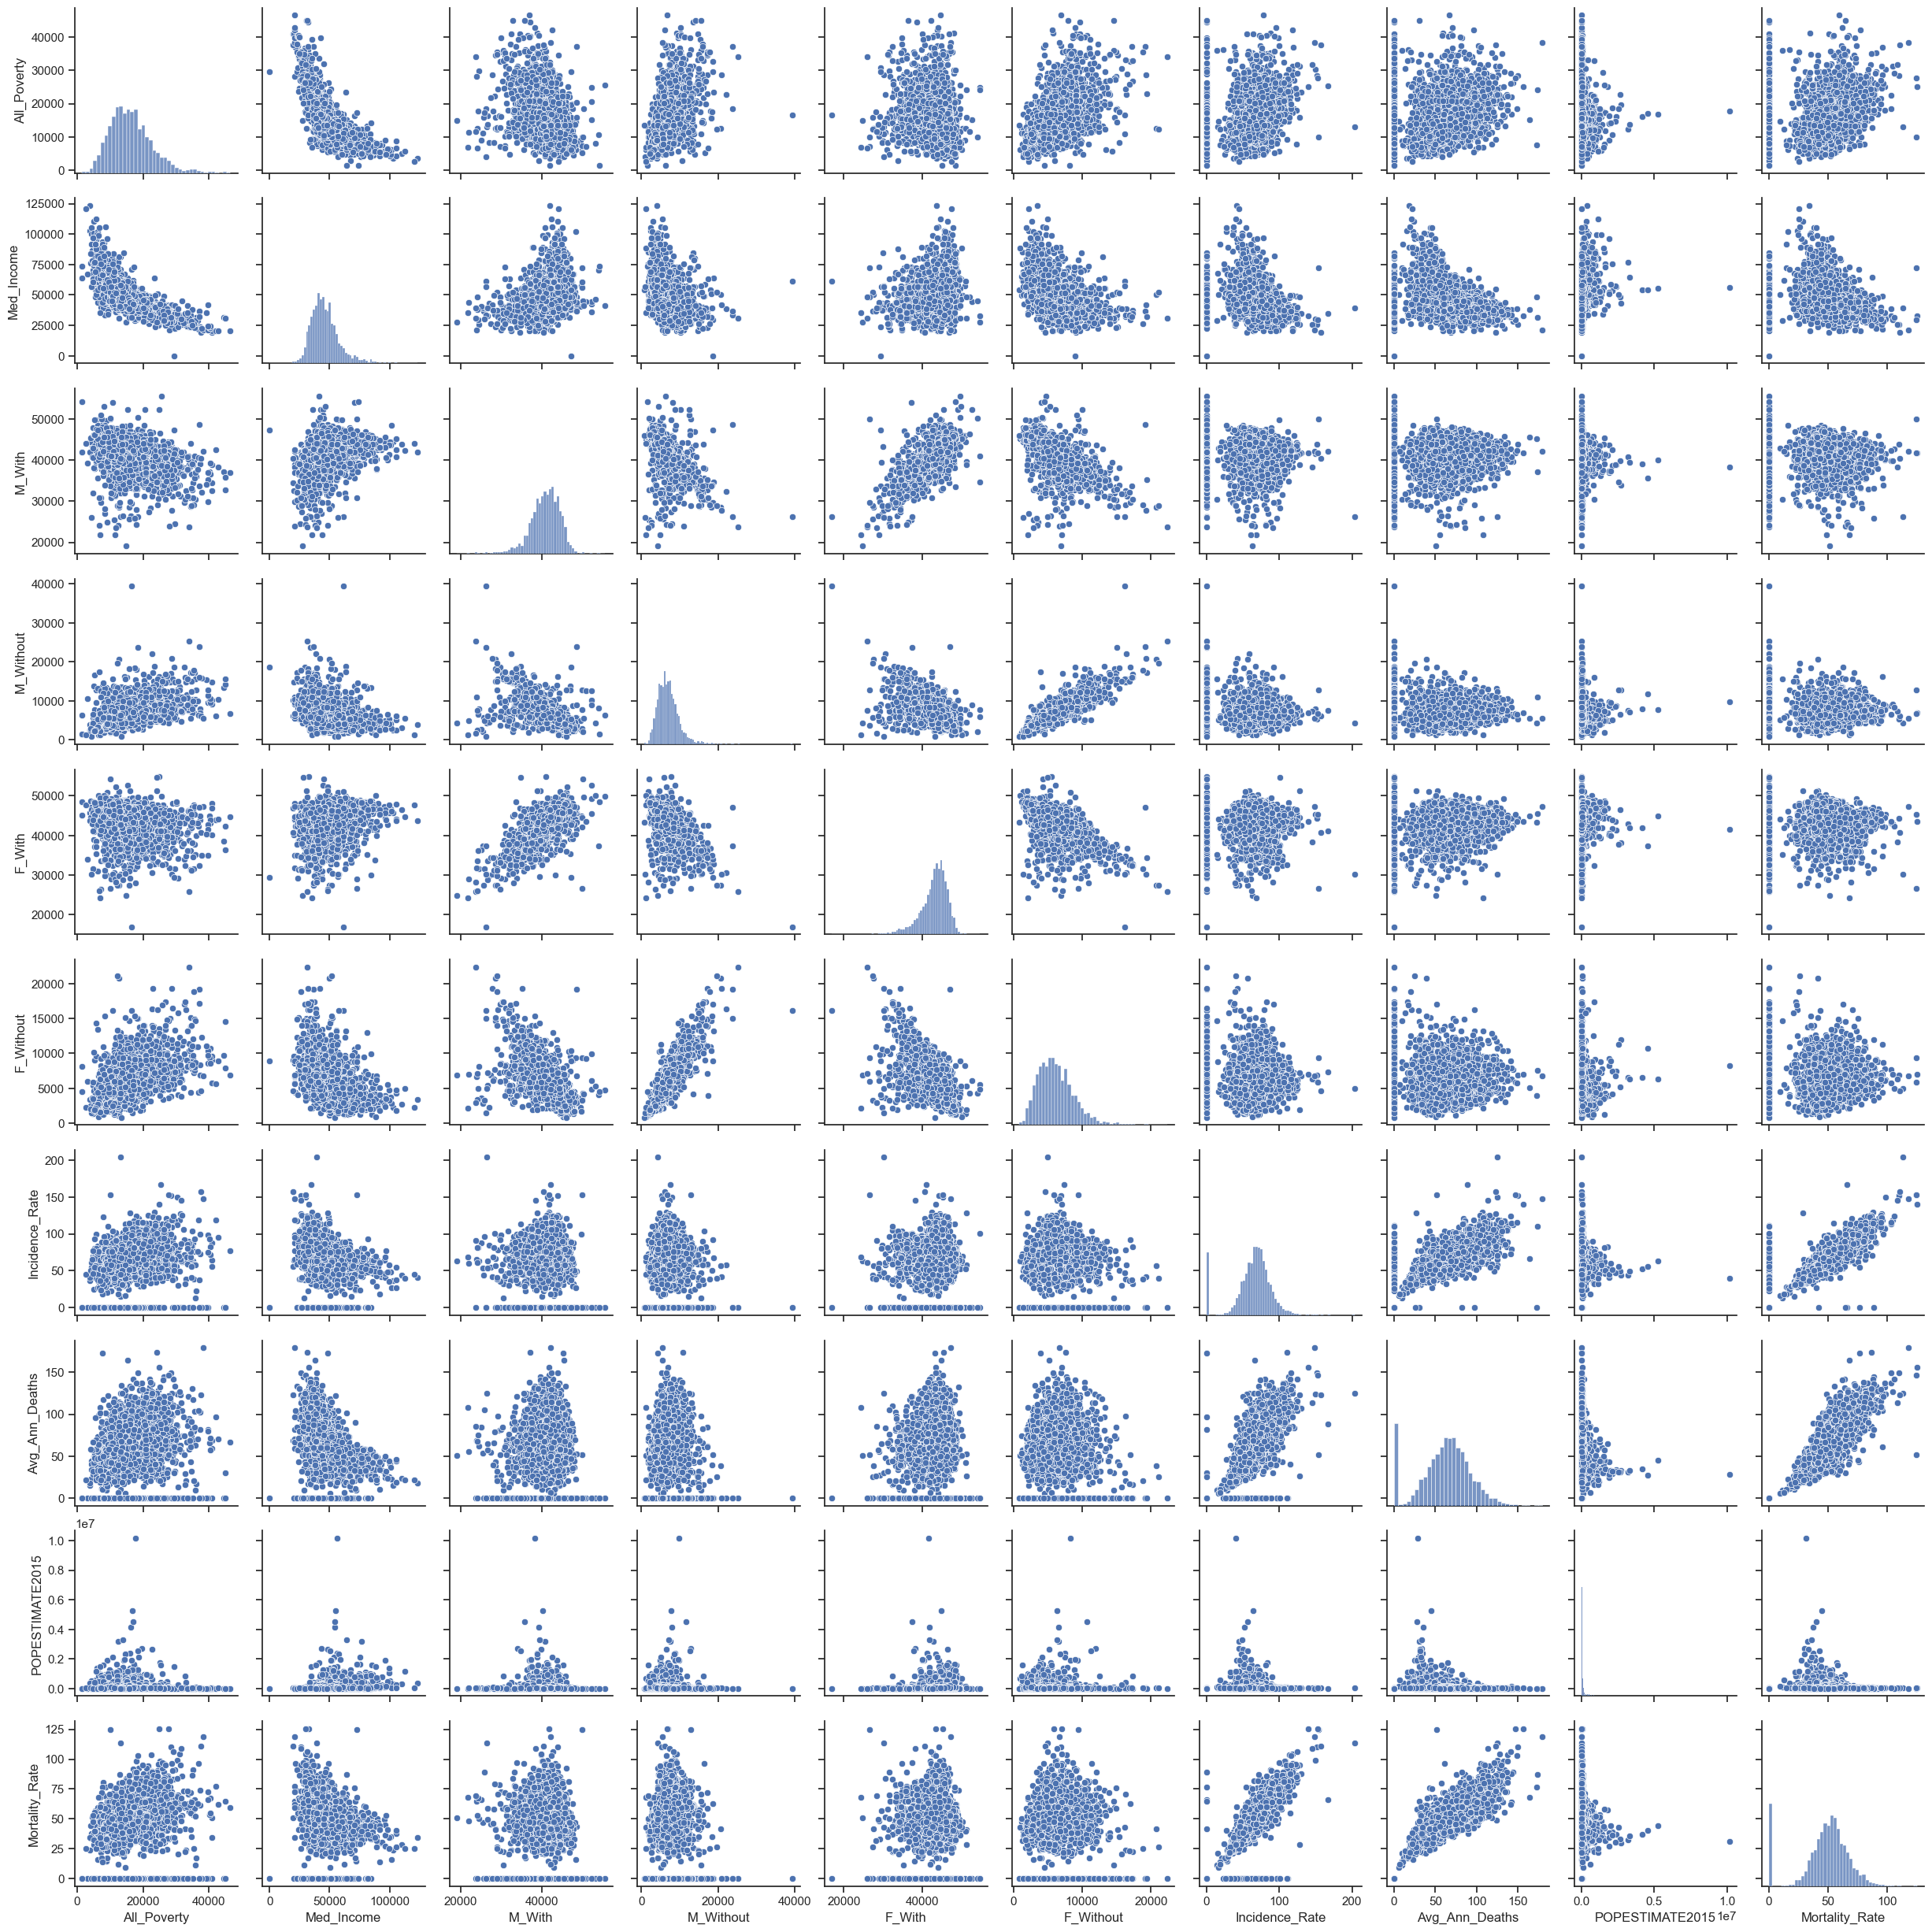

In [25]:
#Revisit the Pairplot with only the uncorrelated features

sub4 = fulldf[["All_Poverty","Med_Income", "M_With", "M_Without","F_With","F_Without","Incidence_Rate", "Avg_Ann_Deaths", "POPESTIMATE2015","Mortality_Rate"]]

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(sub4)

plt.show()




In [26]:
print("From the pairplot we can see the most interesting patterns with mortality rate come from the features POPESTIMATE2015, Avg_Ann_Deaths, Incidence_Rate, Med_Income, All_Poverty")

From the pairplot we can see the most interesting patterns with mortality rate come from the features POPESTIMATE2015, Avg_Ann_Deaths, Incidence_Rate, Med_Income, All_Poverty


## **Part 3: Model Construction [25 Marks]**

### 3.1 Splitting the dataset [5 Marks] 

Split the dataset to three different datasets, train, validation, and test. You choose the ratio for the three datasets and provide a one-sentence rationale on why you went with the ratio.

*Hint*: You can use the validation set approach discussed during tutorials.

In [47]:
#Basic val set approach 50-25-25 from Tutorial 1

fulldf_total = fulldf.sample(frac=1, random_state = 1).reset_index(drop=True)

#Hold out the last 25% of data as Test Set
fulldf_test=fulldf_total[int(0.75*len(fulldf_total)):len(fulldf_total)]

#Build the Training Set
fulldf_train=fulldf_total[0:int(0.75*len(fulldf_total))]

#Indicator for training set, select indicator to seperate test and train sets
np.random.seed(1)
train = np.random.choice(fulldf_train.shape[0], int(2*fulldf_train.shape[0]/3), replace=False)
print(len(train))
select = np.in1d(range(fulldf_train.shape[0]), train)
print(len(select))


print("I chose to use the standard validation set approach, as recommended, which uses 75% of the data for training and validation, 25% of the data for unseen testing. This is warranted by having a dataset of reasonable size, with n>>p. For more accurate evaluation of model performance we could have used cross-validation.")

1462
2193
I chose to use the standard validation set approach, as recommended, which uses 75% of the data for training and validation, 25% of the data for unseen testing. This is warranted by having a dataset of reasonable size, with n>>p.


### 3.2 Model training [15 Marks]
Create three different models, using different features and nonlinear transformations. The purpose of this model is to predict mortality rate of lung cancer with a select set of features. Use the visualizations from section 2.1 to inform the selection of different features.

In [28]:
#Basic Linear Model Using all the Features Left

lm1 = smf.ols ('Mortality_Rate~All_Poverty + Med_Income + M_With + M_Without+F_With+F_Without+Incidence_Rate+Avg_Ann_Deaths+POPESTIMATE2015', data = fulldf_train[select]).fit()


In [29]:
#Basic Linear Model Using only the Features with the most interesting correlations in the Pairplot analysis

lm2 = smf.ols ('Mortality_Rate~Med_Income + POPESTIMATE2015 + Avg_Ann_Deaths+Incidence_Rate + All_Poverty', data = fulldf_train[select]).fit()




In [30]:
#Experimenting with Non-Linear Transformations

lm3 = smf.ols ('Mortality_Rate~All_Poverty + Med_Income +All_Poverty*Med_Income  + M_Without+F_With+Avg_Ann_Deaths+Incidence_Rate + Incidence_Rate*POPESTIMATE2015 +POPESTIMATE2015', data = fulldf_train[select]).fit()


### 3.3 Model selection [5 Marks]
Using different model selection criterion and validation dataset, choose the best perfoming model.

In [31]:
preds1 = lm1.predict(fulldf_train)
square_error1 = (fulldf_train['Mortality_Rate'] - preds1)**2
print('--------Validation Error for Model 1--------')
print(square_error1[~select].mean())

preds2 = lm2.predict(fulldf_train)
square_error2 = (fulldf_train['Mortality_Rate'] - preds2)**2
print('--------Validation Error for Model 2--------')
print(square_error2[~select].mean())

preds3 = lm3.predict(fulldf_train)
square_error3 = (fulldf_train['Mortality_Rate'] - preds3)**2
print('--------Validation Error for Model 3--------')
print(square_error3[~select].mean())




--------Validation Error for Model 1--------
42.54043541007809
--------Validation Error for Model 2--------
44.52223130941302
--------Validation Error for Model 3--------
41.51663537567425


In [32]:
print("We can see that model 3 has the lowest MSE, so we will proceed with this model as our choice.")

We can see that model 3 has the lowest MSE, so we will proceed with this model as our choice.


## **Part 4: Wrapping up [10 marks]**
### 4.1 Model accuracy [5 Marks]
Report the accuracy using MSE on the test set.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
model = LinearRegression()

In [34]:
#Report MSE on the test set
preds_test = lm3.predict(fulldf_test)
square_error = (fulldf_test['Mortality_Rate'] - preds_test)**2
print('--------Test Error for Model 3--------')
print(square_error.mean())

--------Test Error for Model 3--------
43.61405210444492


### 4.2 MSE confidence intervals [5 Marks]
Using bootstraping on the training + validation datasets, find the 95% confidence intervals on mean squared error.

*Hint:* Refer to tutorial 3 on the matter.

In [35]:
# Run 100 iterations of bootstrapping in order to get the average and standard deviation for MSE

MSE=[]
for iteration in range(100):
    boot = resample(fulldf_train, replace=True, n_samples=len(fulldf_train))
    oob_index = [sample for sample in fulldf_train.index if sample not in boot.index]
    oob = fulldf_train.iloc[oob_index]
    model = smf.ols ('Mortality_Rate~All_Poverty + Med_Income +All_Poverty*Med_Income + M_Without+F_With+Avg_Ann_Deaths+Incidence_Rate + Incidence_Rate*POPESTIMATE2015 +POPESTIMATE2015', data = boot).fit()
    preds = model.predict(oob)
    square_error = (fulldf_train['Mortality_Rate'].iloc[oob_index] - preds)**2
    MSE.append(square_error.mean())
print(MSE)
#print(np.mean(MSE))
#print(np.std(MSE))

[51.37990149538718, 45.69789373937129, 44.317287953282126, 49.83749498651465, 49.262386208953174, 44.93374817923953, 46.33207633592948, 52.37899657432794, 42.45989482689052, 50.635452382395194, 54.67841523340459, 44.1482923247956, 45.579895155433896, 48.454576287245175, 49.249141498667335, 48.85614618267385, 51.916961366314396, 46.86335351989439, 49.44816417075231, 48.55223462785104, 50.56476843266884, 42.24713302499605, 43.882838871519105, 44.73951523548208, 45.24114622068608, 50.840528934783535, 48.27660655685361, 49.3052913227162, 50.77632040862557, 48.041320984122066, 49.41449394286162, 39.68860331005449, 49.85052597894875, 43.60655538411627, 44.045182811541764, 54.1509511057562, 47.500582817546245, 46.586811155212814, 47.0848390924797, 46.851914121286065, 47.33537661864648, 46.79545403020008, 48.31584132103391, 48.30659247931626, 51.90367678740444, 39.76383622525707, 48.313234237214274, 50.39044849512461, 52.944204711547, 43.87741705420785, 44.64373288550242, 47.30292631668402, 43

<Figure size 1000x500 with 0 Axes>

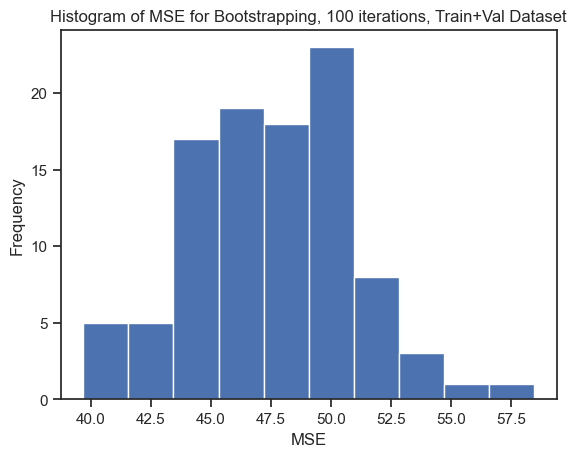

<Figure size 1000x500 with 0 Axes>

In [36]:
#Plot Histogram of the MSE values to see the distribution
plt.hist(MSE)
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title("Histogram of MSE for Bootstrapping, 100 iterations, Train+Val Dataset")
plt.figure(figsize = (10,5))



In [37]:
#Confidence Interval Calculation

#Use numpy percentile

lower = np.percentile(MSE,2.5)
upper = np.percentile(MSE,97.5)

print('%.0f%% confidence interval for MSE: %.1f and %.1f' %(95, lower, upper))

95% confidence interval for MSE: 40.3 and 54.4


**Submission:** Please submit both this notebook and a PDF version of it containing all the code and the outputs.

## **Part 5: Model diagnostics (Bonus) [+10 marks up to full mark]**
Explore model collinearity with `variance_inflation_factor`. Larger values of VIF indicate multicollinearity. Remove the problematic features and recalibrate the model. Report how model R-squared is affected.

*Hint:* You can set VIF > 10 as an indicator of multicollinearity. 

In [38]:
fulldf.head()

,All_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,Incidence_Rate,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
0,16551.930560,61518.0,26219.694702,39419.335528,16941.035618,16162.825501,0.0,0.0,0.000000,3341
1,8751.315328,84306.0,43318.133988,13486.495966,29936.864258,9891.266222,0.0,0.0,0.000000,5702
2,8006.160130,78326.0,40424.848089,7782.185842,40986.959942,7162.155376,61.5,47.3,32.139808,298695
3,24317.396634,51012.0,35640.254096,15089.713585,36927.449014,9885.211189,62.7,58.3,27.861362,17946
4,7735.426009,79750.0,46973.094170,13901.345291,39125.560538,7511.210762,0.0,0.0,0.000000,892


In [39]:
# VIF dataframe

#Look at just features and not response
featuredf = fulldf.drop('Mortality_Rate',axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = featuredf.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(featuredf.values, i) for i in range(len(featuredf.columns))]
  
print(vif_data)

print("Generally, a VIF above 10 indicates a high multicollinearity. The large majority of the features in this model have a VIF greater than 10, this means that there are robust correlations among most of the independent variables.")
print("This high multicollinearity leads to reduced precision of the estimated coefficients for the features, which weakens the statistical power of the regression model. This is because any change in a single feature results in changes in the other variables, since we can no longer claim their independence.")

           feature         VIF
0      All_Poverty   24.517661
1       Med_Income   40.665712
2           M_With  272.610917
3        M_Without   34.114677
4           F_With  334.127155
5        F_Without   31.623161
6   Incidence_Rate   19.613024
7   Avg_Ann_Deaths   14.429318
8  POPESTIMATE2015    1.237192
Generally, a VIF above 10 indicates a high multicollinearity. The large majority of the features in this model have a VIF greater than 10, this means that there are robust correlations among most of the independent variables.
This high multicollinearity leads to reduced precision of the estimated coefficients for the features, which weakens the statistical power of the regression model. This is because any change in a single feature results in changes in the other variables, since we can no longer claim their independence.


In [40]:
#Remove Highest VIFs first and Re-Evaluate

new_df = featuredf[['All_Poverty','Med_Income', 'M_Without','F_Without','Avg_Ann_Deaths', 'Incidence_Rate','POPESTIMATE2015']]

# VIF dataframe
vif_data2 = pd.DataFrame()
vif_data2["feature"] = new_df.columns
  
# calculating VIF for each feature
vif_data2["VIF"] = [variance_inflation_factor(new_df.values, i) for i in range(len(new_df.columns))]

print(vif_data2)

           feature        VIF
0      All_Poverty  12.647551
1       Med_Income   6.210226
2        M_Without  34.031852
3        F_Without  30.497757
4   Avg_Ann_Deaths  12.596642
5   Incidence_Rate  19.246031
6  POPESTIMATE2015   1.171497


In [41]:
#Remove Next Large VIF Values

new_df = new_df.drop('M_Without',axis=1).drop('F_Without',axis=1)

# VIF dataframe
vif_data3 = pd.DataFrame()
vif_data3["feature"] = new_df.columns
  
# calculating VIF for each feature
vif_data3["VIF"] = [variance_inflation_factor(new_df.values, i) for i in range(len(new_df.columns))]
  
print(vif_data3)

           feature        VIF
0      All_Poverty   5.669730
1       Med_Income   4.882631
2   Avg_Ann_Deaths  12.589893
3   Incidence_Rate  18.959845
4  POPESTIMATE2015   1.168331


In [42]:
#Remove Next Largest VIF Value

new_df = new_df.drop('Incidence_Rate',axis=1)

# VIF dataframe
vif_data3 = pd.DataFrame()
vif_data3["feature"] = new_df.columns
  
# calculating VIF for each feature
vif_data3["VIF"] = [variance_inflation_factor(new_df.values, i) for i in range(len(new_df.columns))]
  
print(vif_data3)

           feature       VIF
0      All_Poverty  5.144118
1       Med_Income  3.990472
2   Avg_Ann_Deaths  5.072587
3  POPESTIMATE2015  1.164716


In [43]:
print("Now only features with a VIF less than 10 remain in our dataset. Let's create a new model using only these non-colinear features.")

Now only features with a VIF less than 10 remain in our dataset. Let's create a new model using only these non-colinear features.


In [44]:
#New Model With Removed Colinearities

lm5 = smf.ols ('Mortality_Rate~ Med_Income + POPESTIMATE2015 +Avg_Ann_Deaths + All_Poverty +All_Poverty*Med_Income', data = fulldf_train[select]).fit()

preds5 = lm5.predict(fulldf_train)
square_error5 = (fulldf_train['Mortality_Rate'] - preds5)**2
print('--------Validation Error for Improved VIF Model--------')
print(square_error5[~select].mean())

preds_test5 = lm5.predict(fulldf_test)
square_error_test5 = (fulldf_test['Mortality_Rate'] - preds_test5)**2
print('--------Test Error for Improved VIF Model--------')
print(square_error_test5.mean())

--------Validation Error for Improved VIF Model--------
74.66115029545135
--------Test Error for Improved VIF Model--------
74.49186978279783


In [45]:
print("Although we improved colinearity, we may have removed too many features and now the MSE has become worse than before")
print(" ")

#Let's see how R^2 was affected
rss = sum((fulldf_train['Mortality_Rate'] - preds5)**2)
tss = sum((fulldf_train['Mortality_Rate'] - np.ones(len(fulldf_train['Mortality_Rate']))*fulldf_train.Mortality_Rate.mean())**2)
r2 = 1-rss/tss
print('R^2 of the improved VIF Model')
print(r2)
print(" ")

#Let's compare with our previous R^2
rss_old = sum((fulldf_train['Mortality_Rate'] - preds3)**2)
tss_old = sum((fulldf_train['Mortality_Rate'] - np.ones(len(fulldf_train['Mortality_Rate']))*fulldf_train.Mortality_Rate.mean())**2)
r2_old = 1-rss_old/tss_old
print('R^2 of the Original Model')
print(r2_old)
print(" ")
print("Once again we see that the new model has reduced the R^2, further confirming that the reduced VIF model is not fitting the data quite as well, and is less accurate in prediction.")


Although we improved colinearity, we may have removed too many features and now the MSE has become worse than before
 
R^2 of the improved VIF Model
0.822442549880186
 
R^2 of the Original Model
0.8917483345040791
 
Once again we see that the new model has reduced the R^2, further confirming that the reduced VIF model is not fitting the data quite as well, and is less accurate in prediction.
